# Imports

In [19]:
import torch
import matplotlib.pyplot as plt

In [32]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['figure.figsize'] = (15, 5)

In [33]:
from matplotlib.patches import Rectangle

# Utils

In [5]:
def create_random_bboxes(batch_size, n_diseases, height, width):
    heatmaps = torch.zeros(batch_size, n_diseases, height, width)

    for batch_i in range(batch_size):
        for disease_i in range(n_diseases):
            x_min, y_min = torch.randint(0, 256, (2,)).tolist()
            
            height, width = torch.randint(5, 50, (2,)).tolist()
            x_max = x_min + width
            y_max = y_min + height

            heatmaps[batch_i, disease_i, y_min:y_max, x_min:x_max] = 1
            
    return heatmaps

In [61]:
def plot_box(box, color):
    x_min, y_min, x_max, y_max = box
    width = x_max - x_min
    height = y_max - y_min
    rect = Rectangle((x_min, y_min), width, height, edgecolor=color, fill=False)
    
    ax = plt.gca()
    ax.add_patch(rect)

# Test IoU and IoBB

In [2]:
%run ./iou.py
%run ./iobb.py

## Test one sample

In [50]:
def fill_heatmap(height, width, boxes):
    heatmap = torch.zeros(height, width)

    for x_min, y_min, x_max, y_max in boxes:
        heatmap[y_min:y_max, x_min:x_max] = 1
    return heatmap

In [67]:
def test_one_sample(box_gt, box_pred, height=120, width=120, plot=True):
    # Create maps
    n_diseases = 1
    
    heatmaps = fill_heatmap(height, width, [box_pred])
    gt = fill_heatmap(height, width, [box_gt])
        
    # Prepare for metrics
    heatmaps = heatmaps.unsqueeze(0).unsqueeze(0)
    gt = gt.unsqueeze(0).unsqueeze(0)
    valid = None
    state = (heatmaps, gt, valid)
        
    # Compute metrics    
    miou = IoU(device='cpu')
    miobb = IoBB(device='cpu')
    
    miou.reset()
    miobb.reset()

    miou.update(state)
    miobb.update(state)
    
    value_iou = miou.compute().item()
    value_iobb = miobb.compute().item()
    
    if plot:
        n_rows = 1
        n_cols = 3

        plt.subplot(n_rows, n_cols, 1)
        plot_box(box_gt, 'green')
        plot_box(box_pred, 'red')
        plt.ylim(0, height)
        plt.xlim(0, width)
        plt.title('Boxes')
        plt.gca().invert_yaxis()

        plt.subplot(n_rows, n_cols, 2)
        plt.imshow(gt[0, 0])
        plt.title('GT')
        plt.axis('scaled')

        plt.subplot(n_rows, n_cols, 3)
        plt.imshow(heatmaps[0, 0])
        plt.title('Heatmap')
        plt.axis('scaled')
    
    return value_iou, value_iobb

### Regular sample

(0.1428571492433548, 0.25)

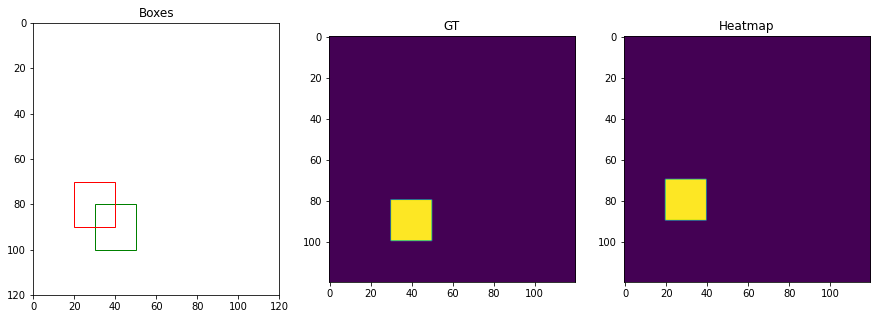

In [59]:
iou, iobb = test_one_sample(
    (30, 80, 50, 100), # gt
    (20, 70, 40, 90), # pred
)
iou, iobb

### Prediction inside BB

0.1666666716337204 0.1666666716337204


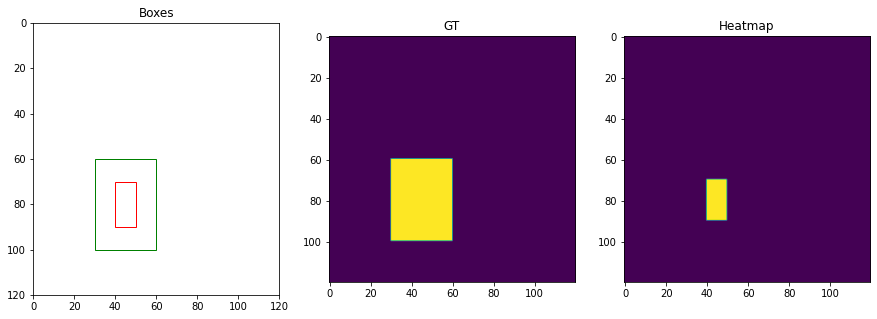

In [68]:
iou, iobb = test_one_sample(
    (30, 60, 60, 100), # gt
    (40, 70, 50, 90), # pred
)
print(iou, iobb)
assert abs(iou - iobb) <= 1e-3

### BB inside prediction

0.1666666716337204 1.0


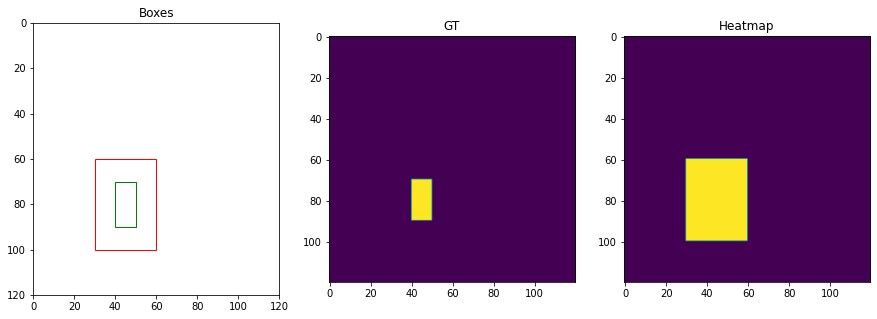

In [63]:
iou, iobb = test_one_sample(
    (40, 70, 50, 90),
    (30, 60, 60, 100),
)
print(iou, iobb)
assert abs(iobb - 1) <= 1e-2

### Pred outside of BB

0.0 0.0


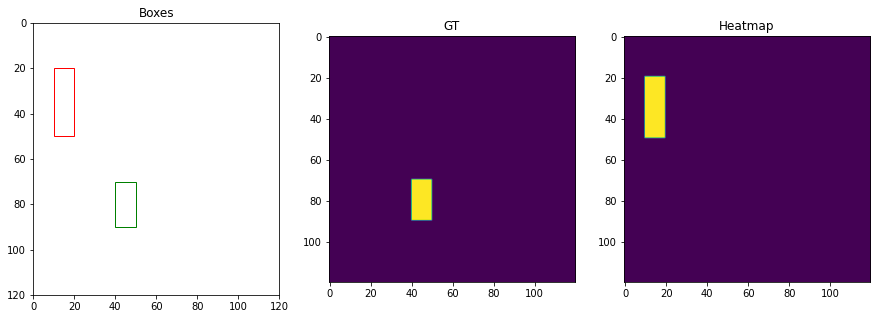

In [66]:
iou, iobb = test_one_sample(
    (40, 70, 50, 90),
    (10, 20, 20, 50),
)
print(iou, iobb)
assert abs(iobb - 0) <= 1e-2
assert abs(iou - 0) <= 1e-2

## Test multiple samples

Averages correctly

In [69]:
boxes = [
    ((30, 80, 50, 100), (20, 70, 40, 90)), # Regular
    ((30, 60, 60, 100), (40, 70, 50, 90)), # GT eats Pred
    ((40, 70, 50, 90), (30, 60, 60, 100)), # Pred eats GT
    ((40, 70, 50, 90), (10, 20, 20, 50)), # Non-overlapping
]

In [71]:
average_iou = average_iobb = 0

for box_gt, box_pred in boxes:
    iou, iobb = test_one_sample(box_gt, box_pred, plot=False)
    
    average_iou += iou
    average_iobb += iobb
    
n_tests = len(boxes)
average_iou /= n_tests
average_iobb /= n_tests
average_iou, average_iobb

(0.1190476231276989, 0.3541666679084301)

In [75]:
AVERAGE_IOU = average_iou
AVERAGE_IOBB = average_iobb

### Utils

In [115]:
def test_multiple_samples_1(target, height=120, width=120, tolerance=1e-2):
    """Tests averages correctly across:
    
    target == 'bs': batch_size
    target == 'd': n_diseases
    target == 'both': both
    """
    heatmaps = []
    gt = []
    for box_gt, box_pred in boxes:
        heatmaps.append(fill_heatmap(height, width, [box_pred]))
        gt.append(fill_heatmap(height, width, [box_gt]))

    heatmaps = torch.stack(heatmaps, dim=0)
    gt = torch.stack(gt, dim=0)
    
    if target == 'bs':
        heatmaps = heatmaps.unsqueeze(1)
        gt = gt.unsqueeze(1)
    elif target == 'd':
        n_diseases = len(boxes)
        heatmaps = heatmaps.unsqueeze(0)
        gt = gt.unsqueeze(0)
    elif target == 'both':
        n_diseases = 2
        n_samples = len(boxes) // n_diseases
        heatmaps = heatmaps.view(n_samples, n_diseases, height, width)
        gt = gt.view(n_samples, n_diseases, height, width)
    else:
        raise Exception(f'Not recognized: {target}')

        
    # Compute metrics    
    miou = IoU(device='cpu')
    miobb = IoBB(device='cpu')

    miou.reset()
    miobb.reset()

    state = (heatmaps, gt, None)
    miou.update(state)
    miobb.update(state)

    value_iou = miou.compute()
    value_iobb = miobb.compute()

    if target == 'bs':
        assert value_iou.size() == (1,)
        assert value_iobb.size() == (1,)
    elif target in ('d', 'both'):
        assert value_iou.size() == (n_diseases,)
        assert value_iobb.size() == (n_diseases,)
    
    value_iou = value_iou.mean().item()
    value_iobb = value_iobb.mean().item()

    if abs(value_iou - AVERAGE_IOU) >= tolerance:
        print(f'IoU wrong, got: {value_iou}, expected: {AVERAGE_IOU}')
    if abs(value_iobb - AVERAGE_IOBB) >= tolerance:
        print(f'IoBB wrong, got: {value_iobb}, expected: {AVERAGE_IOBB}')
    
    return value_iou, value_iobb

### Averages correctly across batch_size

In [116]:
test_multiple_samples_1('bs', tolerance=1e-2)

(0.1190476268529892, 0.3541666865348816)

### Averages correctly across n_diseases

In [117]:
test_multiple_samples_1('d', tolerance=1e-2)

(0.1190476268529892, 0.3541666865348816)

### Across both batch_size and n_diseases

In [118]:
test_multiple_samples_1('both', tolerance=1e-2)

(0.1190476268529892, 0.3541666567325592)